## Hands on lecture: train TFL net

 In this hands-on lecture, we will train a model for predicting Traffic-light (TFL) in image patches, you will use the data generated in previous course to this end.
 You will :
 1. Evaluate the data previously generated and ensure it's validity.
 2. Train a CNN 
 3. Evaluate results of the trained model.
 4. seek ways to improve results

In [1]:
%reload_ext autoreload
%autoreload 2
%autosave 120
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from os.path import join

Autosaving every 120 seconds


Using TensorFlow backend.
/localhomes/dorie/virt/lvpy36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/localhomes/dorie/virt/lvpy36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/localhomes/dorie/virt/lvpy36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/localhomes/dorie/virt/lvpy36/lib/p

## Step 1. Validate your data
    use the example in the cell below, to verify the TFL patch you've generated is sane.
    Things to watch for:
    1. You are able to load and vizualize your train and val data, using the functions below.
    2. using the vizualization verify  image <--> label correspondence is correct.
    3. % Negative vs. Positive examples is aprroximately 50%
 

val :  (582, 81, 81, 3) 0/1 split 50.0 %
train :  (3316, 81, 81, 3) 0/1 split 50.0 %


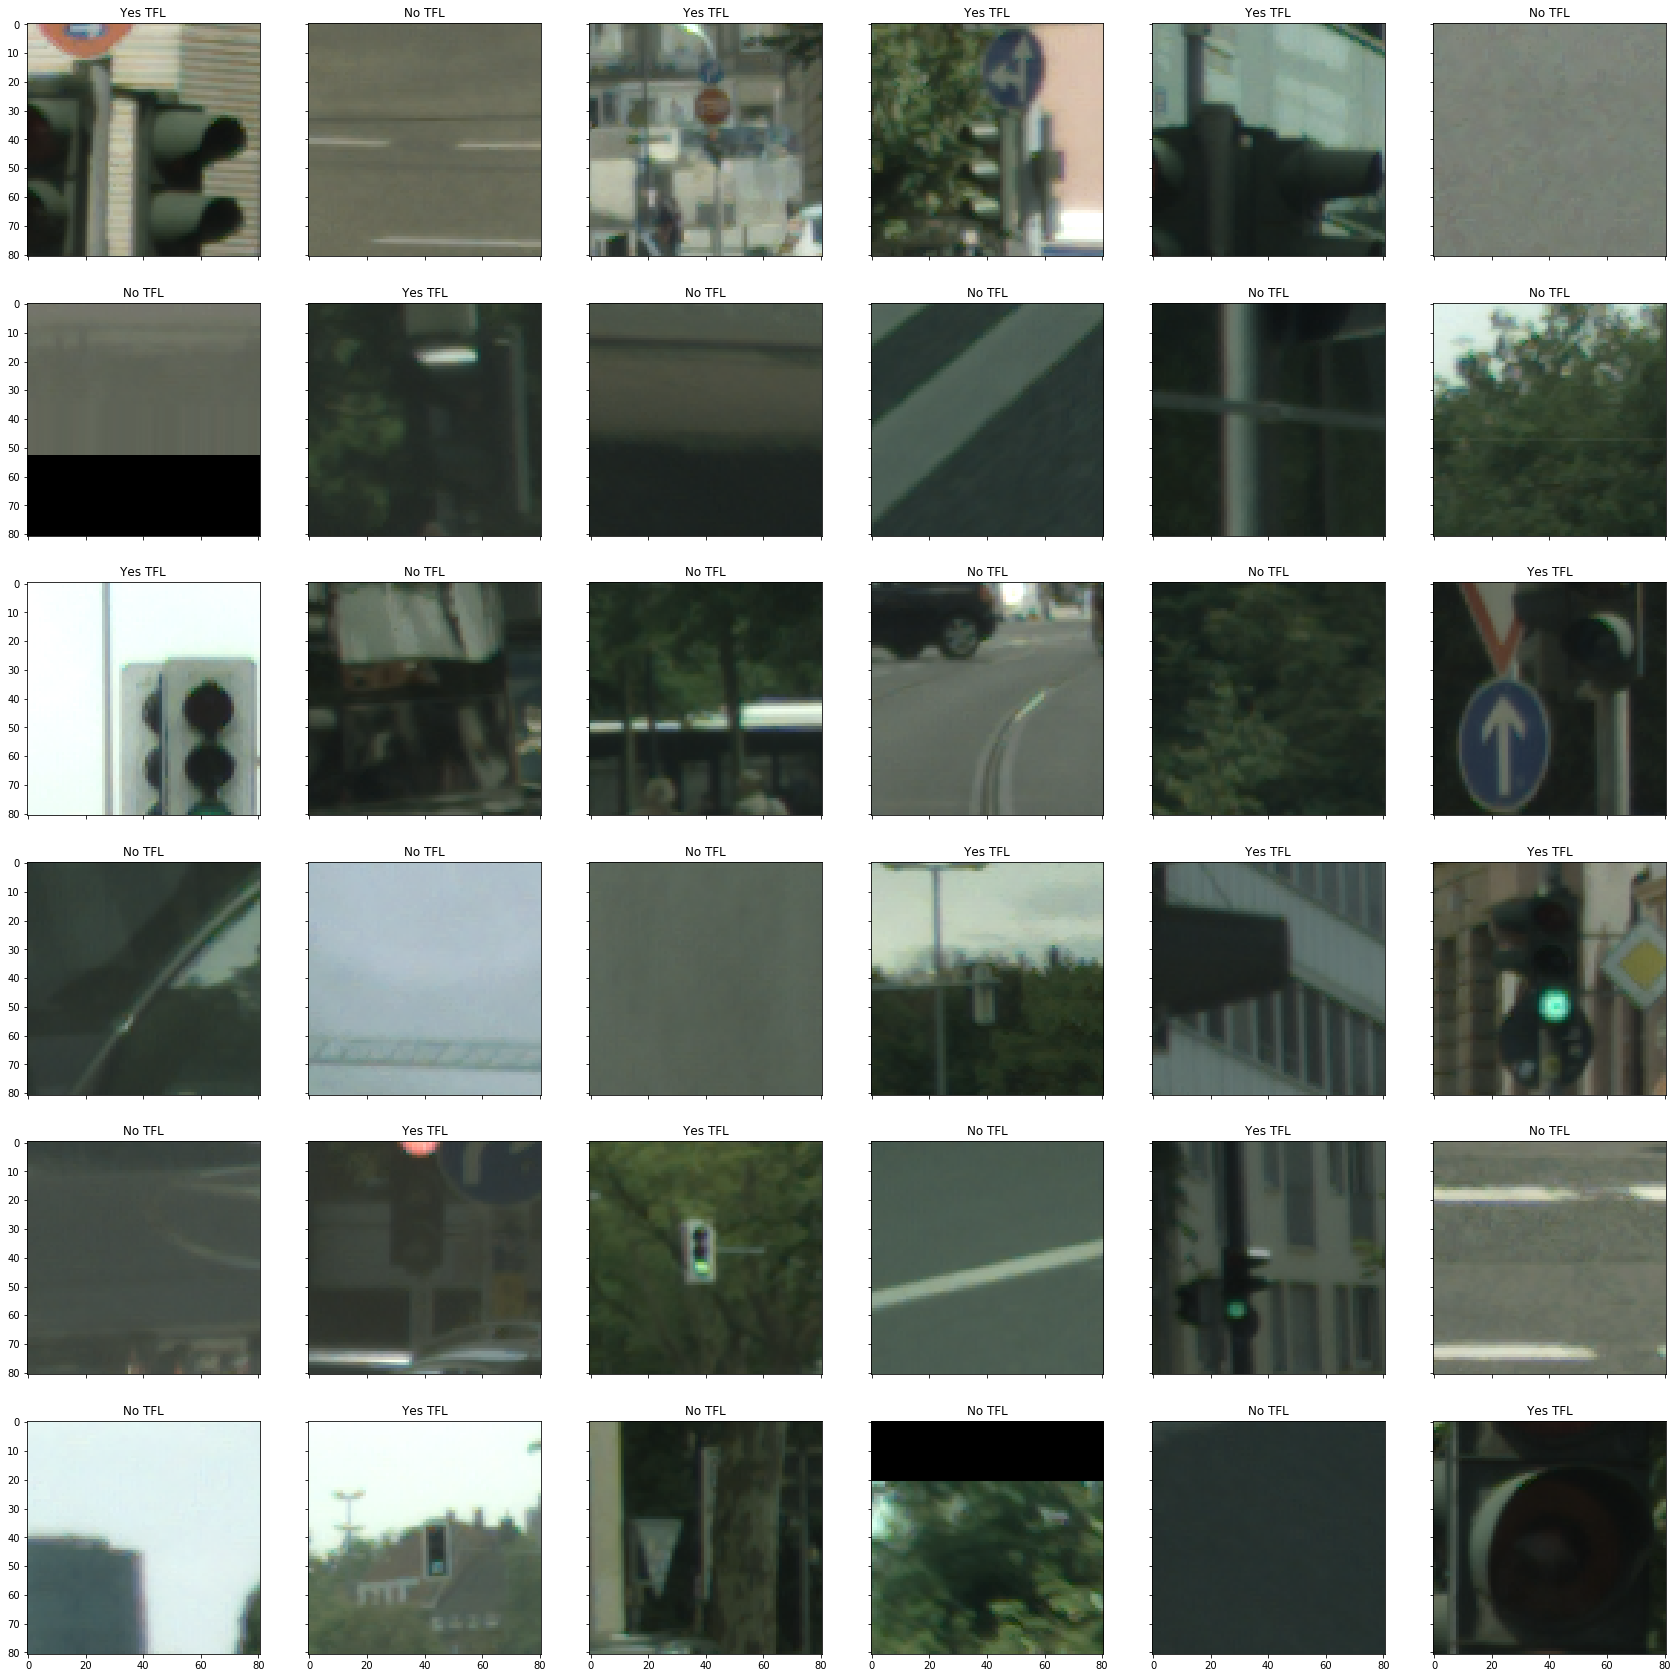

In [2]:
def load_tfl_data(data_dir, crop_shape=(81,81)):
    images = np.memmap(join(data_dir,'data.bin'),mode='r',dtype=np.uint8).reshape([-1]+list(crop_shape) +[3])
    labels = np.memmap(join(data_dir,'labels.bin'),mode='r',dtype=np.uint8)
    return {'images':images,'labels':labels}

def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {:.2f}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)
   

root = './'  #this is the root for your val and train datasets
datasets = {
    'val':load_tfl_data(join(root,'val')),
    'train': load_tfl_data(join(root,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(6,6),**datasets['val'])   

## define the model used for training


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation
from tensorflow.keras.layers.convolutional import Conv2D

def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=False, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=False,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,32) 
    spatial_layer(2,64)
    spatial_layer(2,96) 
    
    
    model.add(Flatten())
    dense_bn_relu(96)
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 79, 79, 32)        864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 79, 79, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 32)        9216      
_________________________________________________________________
batch_normalization_2 (Batch (None, 77, 77, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 32)       

## train

In [4]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
root = './'
datasets = {
    'val':load_tfl_data(join(root,'val')),
    'train': load_tfl_data(join(root,'train')),
    }
#prepare our model
m = tfl_model()
m.compile(optimizer=tensorflow.keras.optimizers.Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 10)


Train on 3316 samples, validate on 582 samples
Epoch 1/10
3316/3316 [==============================] - 58s 18ms/step - loss: 0.4721 - accuracy: 0.7729 - val_loss: 0.5007 - val_accuracy: 0.8007
Epoch 2/10
3316/3316 [==============================] - 57s 17ms/step - loss: 0.3680 - accuracy: 0.8341 - val_loss: 0.4380 - val_accuracy: 0.8144
Epoch 3/10
3316/3316 [==============================] - 57s 17ms/step - loss: 0.3252 - accuracy: 0.8552 - val_loss: 0.3788 - val_accuracy: 0.8368
Epoch 4/10
3316/3316 [==============================] - 61s 18ms/step - loss: 0.3082 - accuracy: 0.8658 - val_loss: 0.5751 - val_accuracy: 0.7715
Epoch 5/10
3316/3316 [==============================] - 60s 18ms/step - loss: 0.2782 - accuracy: 0.8797 - val_loss: 0.3559 - val_accuracy: 0.8436
Epoch 6/10
3316/3316 [==============================] - 60s 18ms/step - loss: 0.2312 - accuracy: 0.9050 - val_loss: 0.4651 - val_accuracy: 0.7955
Epoch 7/10
3316/3316 [==============================] - 59s 18ms/step - loss

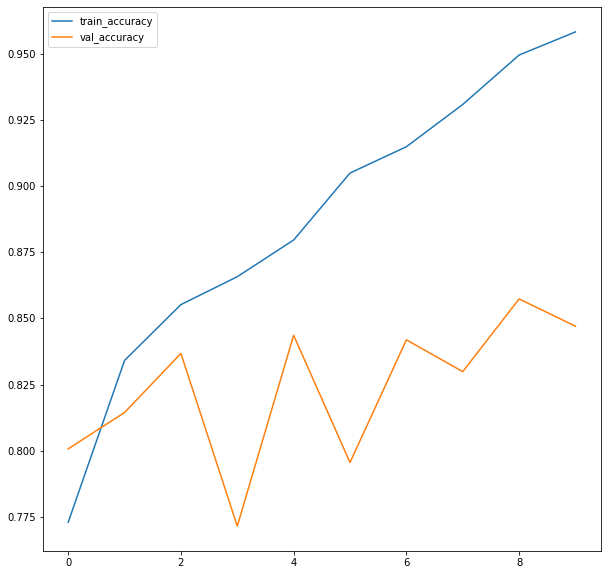

In [5]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_accuracy'] = epochs['accuracy']
plt.figure(figsize=(10,10))
for k in ['train_accuracy','val_accuracy']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

## evaluate and predict
Now thet we have a model we can use to predict results on the validation dataset.
1. What can say about example that fail prediction? can we find patterns that are common for failure cases?

accuracy: 0.8470790378006873


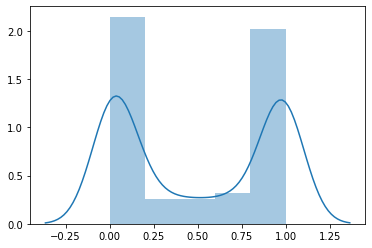

In [6]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

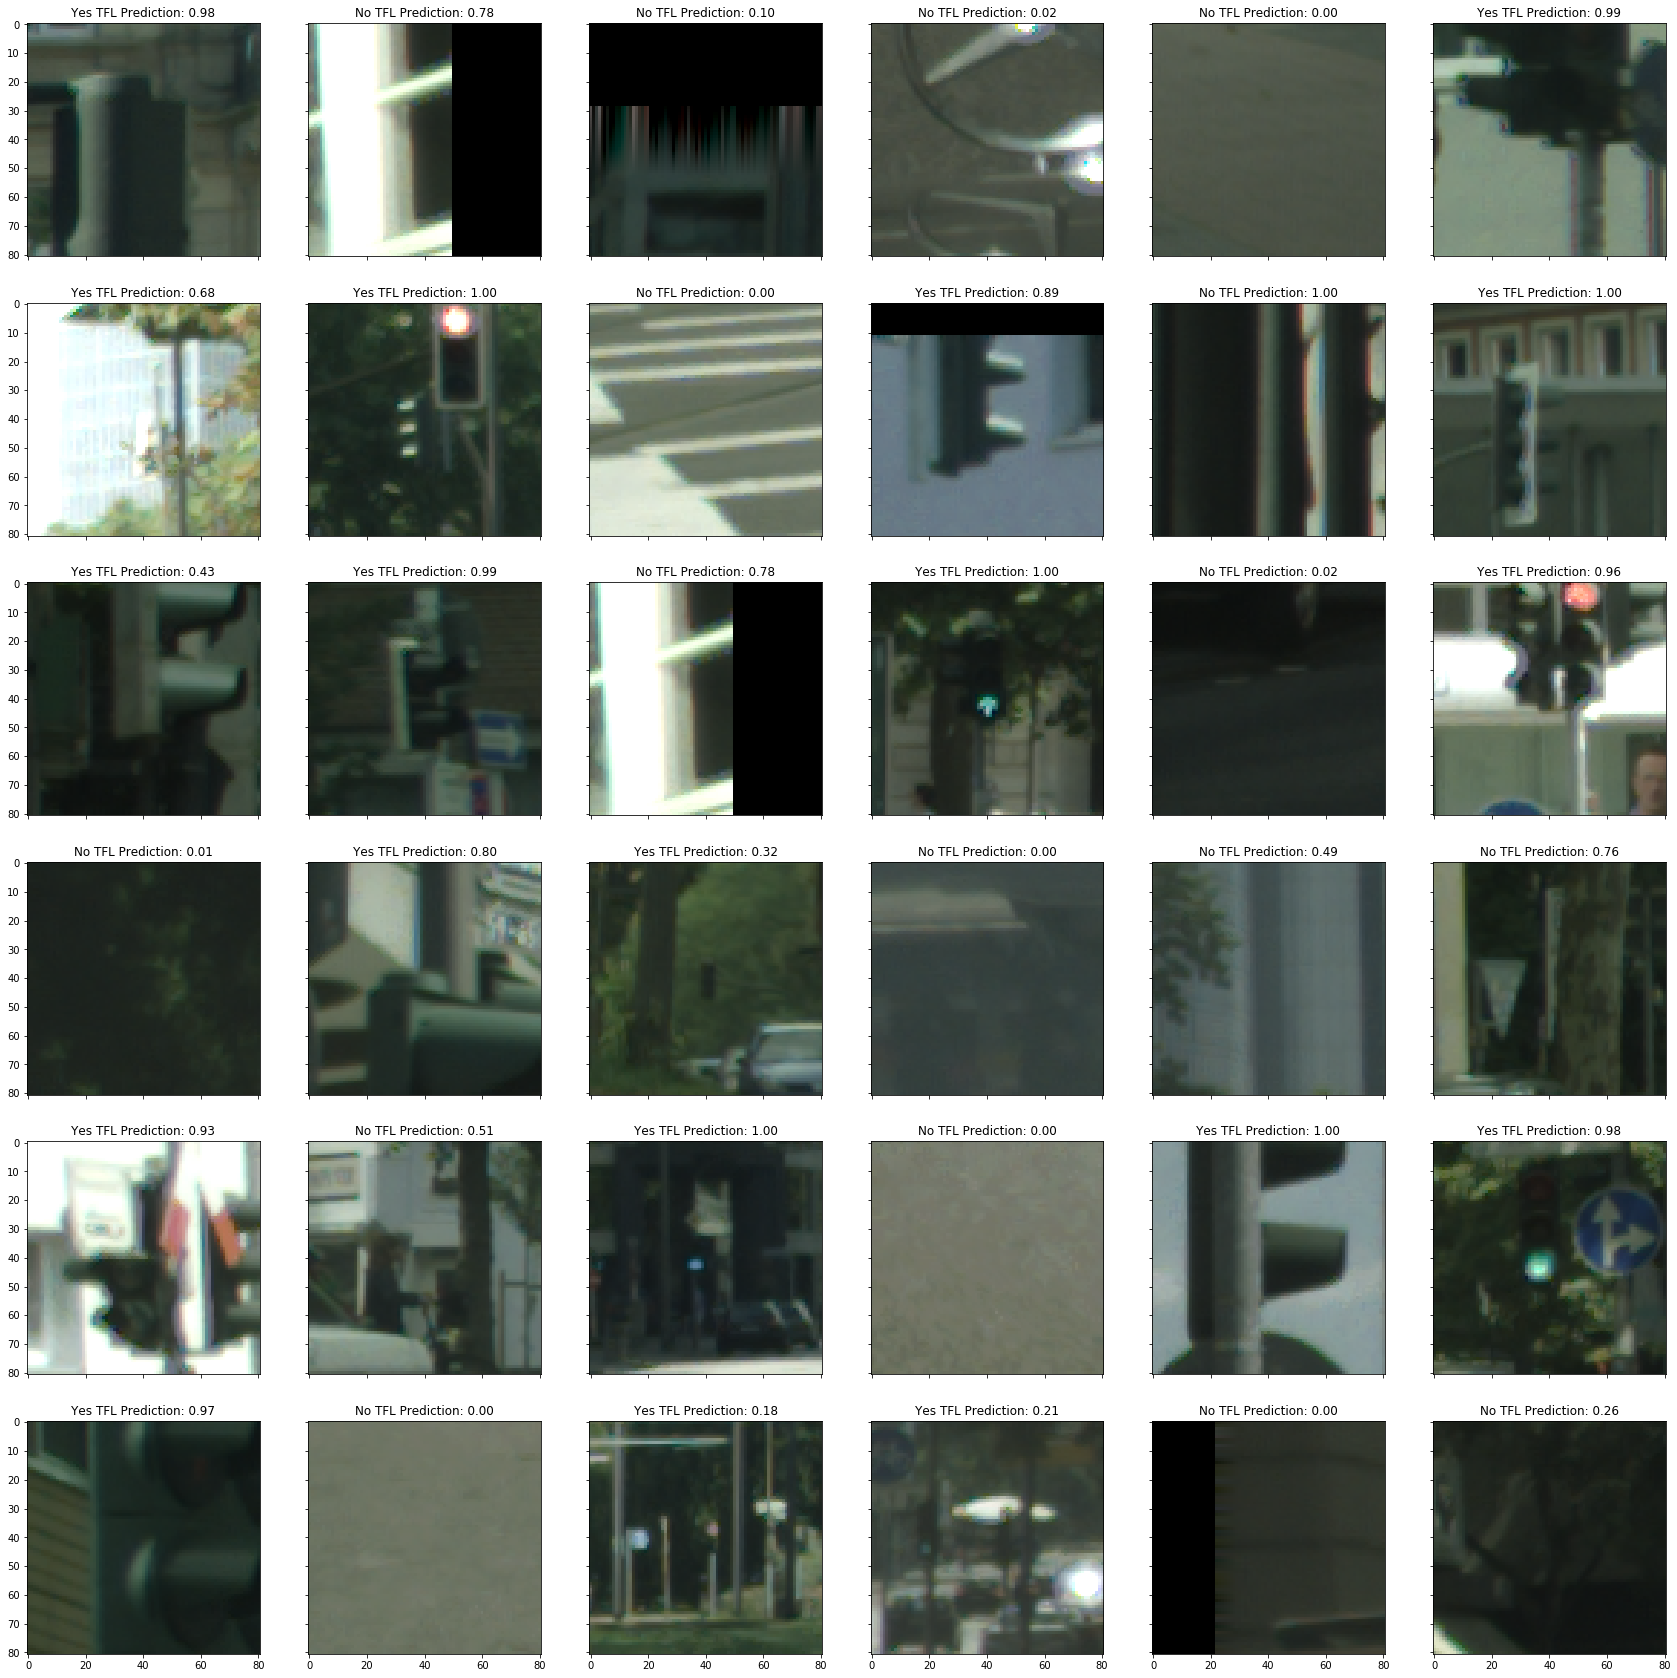

In [7]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

### Seek ways to improve resutls 
1. Try to play with diffferent models , increase / decrease the number of conv layers or number of  filters. you'll need to find a balanced model that is sufficiently large but minimzes overfit
    - try to enable tensorboard vizualization (see keras/ tensorboard doc) to help you carry the analysis
2. Data augmentation: feed your network with more examples by using data augmentation techniques: such as horizontal image flip, noise, etc

### Saving the model
After we trained our model and made predictions with it, we will now want to save the **architecture** together with its learned **weights** in order for us to be able to use it in the TFL manager.
The architecture will be saved as a json, the weights in the h5 format: 

In [11]:
m.save("model.h5")

In [8]:
# json_filename = 'model.json'
# h5_filename   = 'weights.h5'
# # create a json with the model architecture
# model_json = m.to_json()
# # save the json to disk
# with open(json_filename, 'w') as f:
#     f.write(model_json)
# # save the model's weights:
# m.save_weights(h5_filename)
# print(" ".join(["Model saved to", json_filename, h5_filename]))

Model saved to model.json weights.h5


### Loading the model

In [ ]:
from keras.models import load_model
loaded_model = load_model("model.h5")

In [101]:
# with open(json_filename, 'r') as j:
#     loaded_json = j.read()

# # load the model architecture: 
# loaded_model = keras.models.model_from_json(loaded_json)
# #load the weights:
# loaded_model.load_weights(h5_filename)
# print(" ".join(["Model loaded from", json_filename, h5_filename]))

Model loaded from model.json weights.h5


accuracy: 0.8470790378006873


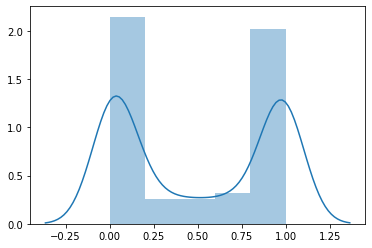

In [10]:
# code copied from the training evaluation: 
l_predictions = loaded_model.predict(val['images'])
sbn.distplot(l_predictions[:,0]);

l_predicted_label = np.argmax(l_predictions, axis=-1)
print ('accuracy:', np.mean(l_predicted_label==val['labels']))